<a href="https://colab.research.google.com/github/Santhoshkumar-p/stock-prediction/blob/master/stock_prediction_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library Imports

In [95]:
!pip install torchsummaryX wandb --quiet

In [96]:
import torch
from torch.utils.data import Dataset
import numpy as np
from torchsummaryX import summary
import sklearn
import gc
import zipfile
import pandas as pd
from tqdm.auto import tqdm
import os
import urllib.request
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import requests
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cpu


In [97]:
%pip install yfinance

## Config and Constant Initializations

In [98]:
DATA_DIR = ''
S_P_500_URL = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/main/data/constituents.csv"
PRICING_URL = "https://finance.google.com/finance/historical?" \
           "output=csv&q={0}&startdate=Jan+1%2C+1980&enddate={1}"
SYMBOLS_FILE = 'stocks.csv'
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'

In [99]:
config = {
    'epochs'        : 500,
    'batch_size'    : 10,#no of sample instances in one batch
    'parition_size' : 0.50,
    'input_size'    : 1,#Feature Length
    'num_steps'     : 10,#Time Steps
    'init_lr'       : 1e-3,
    'dropout'       : 0.3,
    'num_layers'    : 1,
    'hidden_size'   : 128,
    'architecture'  : 'stock-prediction-lstm'
}

# 1. Stock Predicition with Historical Data

## 1. Import GME Stock Data

Get Stock Datasets from Yahoo Finance Dataloader

In [44]:
def load_stock_prices(symbol, START_DATE, END_DATE):
    data = yf.download(symbol, start=START_DATE, end=END_DATE)
    try:
        FILE_DEST = os.path.join(DATA_DIR, symbol+'.csv')
        if data is not None:
            data.to_csv(FILE_DEST)
        if os.path.exists(FILE_DEST):
            print('Stock price fetched successfully for ',symbol)
    except Exception:
        print("Exception occured while fetchicg stock price data for ",symbol)

In [105]:
load_stock_prices('GME', '2020-01-01', '2022-12-01')

[*********************100%%**********************]  1 of 1 completed

Stock price fetched successfully for  GME


In [106]:
data = pd.read_csv('GME.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1.5350,1.6175,1.5175,1.5775,1.5775,17814400
1,2020-01-03,1.5525,1.5625,1.4600,1.4700,1.4700,14175600
2,2020-01-06,1.4500,1.4775,1.4000,1.4625,1.4625,13579200
3,2020-01-07,1.4425,1.4575,1.3600,1.3800,1.3800,20912000
4,2020-01-08,1.3725,1.4625,1.3525,1.4300,1.4300,22517600


## 2. Exploratory Data Analysis - GME

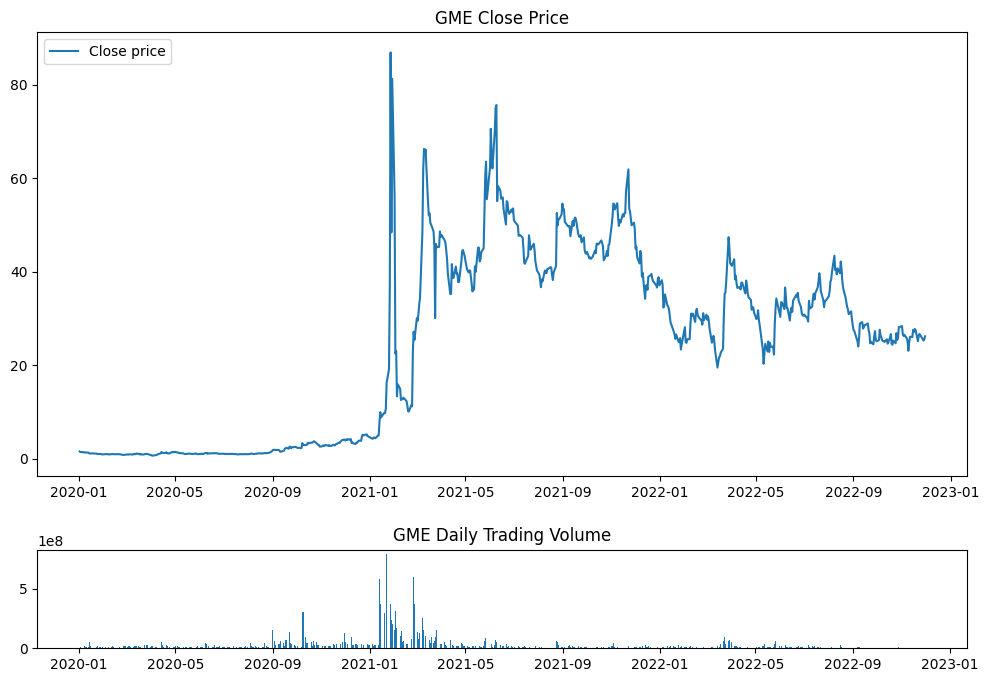

In [107]:
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(pd.to_datetime(data['Date']), data['Close'], label = 'Close price')
plt.title('GME Close Price')
plt.legend(loc=2)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(pd.to_datetime(data['Date']), data["Volume"])
plt.title('GME Daily Trading Volume')
plt.gcf().set_size_inches(12,8)
plt.subplots_adjust(hspace=0.75)

## 3. Feature Extraction
 We are getting 'Close' price of busines day over the year 2021

In [108]:
features = ['Date','Close']
data = pd.DataFrame(data, columns=features)
data.head()


,Date,Close
0,2020-01-02,1.5775
1,2020-01-03,1.4700
2,2020-01-06,1.4625
3,2020-01-07,1.3800
4,2020-01-08,1.4300


Normalize 'Close' price to have **standard normalization** to reduce variance

In [109]:
data.sort_index()
scaler = MinMaxScaler(feature_range=(0,1))
data[['Close']]= scaler.fit_transform(data[['Close']])
data.head()

,Date,Close
0,2020-01-02,0.010182
1,2020-01-03,0.008935
2,2020-01-06,0.008848
3,2020-01-07,0.007891
4,2020-01-08,0.008471


Process **'Close'** price data and add **t-(num_steps)** for RNN to understand the timeseries

In [110]:
for i in range(1, config['num_steps']):
     data[f'Close(t-{i})'] = data['Close'].shift(i)
     data.dropna(inplace=True)
data.head()

,Date,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9)
45,2020-03-09,0.002611,0.003249,0.003365,0.002814,0.002408,0.002988,0.002321,0.001944,0.001712,0.002205
46,2020-03-10,0.004148,0.002611,0.003249,0.003365,0.002814,0.002408,0.002988,0.002321,0.001944,0.001712
47,2020-03-11,0.003887,0.004148,0.002611,0.003249,0.003365,0.002814,0.002408,0.002988,0.002321,0.001944
48,2020-03-12,0.003423,0.003887,0.004148,0.002611,0.003249,0.003365,0.002814,0.002408,0.002988,0.002321
49,2020-03-13,0.005193,0.003423,0.003887,0.004148,0.002611,0.003249,0.003365,0.002814,0.002408,0.002988


Reverse **(t-k)** columns, from oldest **(t-k)** to **(t-1)** until **t**

In [111]:
data = data[data.columns.tolist()[:1] + data.columns.tolist()[1:][::-1]]
data.head()

,Date,Close(t-9),Close(t-8),Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1),Close
45,2020-03-09,0.002205,0.001712,0.001944,0.002321,0.002988,0.002408,0.002814,0.003365,0.003249,0.002611
46,2020-03-10,0.001712,0.001944,0.002321,0.002988,0.002408,0.002814,0.003365,0.003249,0.002611,0.004148
47,2020-03-11,0.001944,0.002321,0.002988,0.002408,0.002814,0.003365,0.003249,0.002611,0.004148,0.003887
48,2020-03-12,0.002321,0.002988,0.002408,0.002814,0.003365,0.003249,0.002611,0.004148,0.003887,0.003423
49,2020-03-13,0.002988,0.002408,0.002814,0.003365,0.003249,0.002611,0.004148,0.003887,0.003423,0.005193


Apply Date Filter from **START_DATE(2021-01-01)** to **END_DATE(2021-12-31)**

In [112]:
data = data[(data['Date'] >= START_DATE) & (data['Date'] <= END_DATE)]
data.head()


,Date,Close(t-9),Close(t-8),Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1),Close
253,2021-01-04,0.037220,0.036930,0.048330,0.051551,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919
254,2021-01-05,0.036930,0.048330,0.051551,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.042267
255,2021-01-06,0.048330,0.051551,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.042267,0.045139
256,2021-01-07,0.051551,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.042267,0.045139,0.044327
257,2021-01-08,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.042267,0.045139,0.044327,0.043196


## 4. Dataset - Stock Data Modeling

Declaration of a generic dataset using torch.utils.data.Dataset.

In [17]:
class StockDataset(Dataset):
  def __init__(self, x, y):
    assert len(x) == len(y)
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self,i):
    return torch.from_numpy(np.array(self.x[i]).astype(float)), torch.from_numpy(np.array(self.y[i]).astype(float))

Divide the complete 2021 trading data of GME into segments designated for training and testing purposes.

In [18]:
def train_test_split(data, num_steps=config['num_steps'], parition_size=config['parition_size'], include_sentiment=False):
  #assert data != None
  #data = data[(data['Date'] >= START_DATE) & (data['Date'] <= END_DATE)]
  if include_sentiment
    x = data.to_numpy()[:, 1:num_steps]
    y = data.to_numpy()[:, -1]
  else:
    x = data.to_numpy()[:, 1:num_steps]
    y = data.to_numpy()[:, -1]
  split_size = int(len(x) * parition_size)
  train_x, test_x = x[:split_size, :], x[split_size:, :]
  train_y, test_y = y[:split_size], y[split_size:]
  return train_x, test_x, train_y, test_y


 Divide stock data into training and testing sets, create corresponding datasets, and initializes data loaders for efficient processing.

In [19]:
dates = data['Date']
train_x, test_x, train_y, test_y = train_test_split(data)

train_stock_data = StockDataset(train_x, train_y)
test_stock_data = StockDataset(test_x, test_y)
train_stock_loader = torch.utils.data.DataLoader(train_stock_data, batch_size=config['batch_size'], shuffle=True)
test_stock_loader = torch.utils.data.DataLoader(test_stock_data, batch_size=config['batch_size'], shuffle=False)

print("Train dataset samples = {}, batches = {}".format(train_stock_data.__len__(), len(train_stock_loader)))
print("Test dataset samples = {}, batches = {}".format(test_stock_data.__len__(), len(test_stock_loader)))

Train dataset samples = 103, batches = 11
Test dataset samples = 103, batches = 11


In [20]:
for i, data in enumerate(train_stock_loader):
  features, labels = data[0], data[1]
  print("Train dataset features shape = {}, lables shape = {}".format(features.shape, labels.shape))
  break

Train dataset features shape = torch.Size([10, 9]), lables shape = torch.Size([10])


## 5. LSTM Based Stock Prediction Model
 - Utilizes Long Short-Term Memory (LSTM) architecture for sequence prediction.
 - Well-suited for time-series data and sequential patterns.
 - Capable of capturing long-term dependencies in data.
 - Contains input, hidden, and output layers.
 - Input data is processed sequentially through LSTM layers.
 - Final output provides predictions based on learned patterns.
 - Effective for tasks like stock price prediction, language modeling, and more

In [21]:
class StockPredictionModel(torch.nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        #print(f'LSTM size {lstm_out.shape}')
        y = self.linear(lstm_out)
        return y


## 6. Training Procedure for LSTM Prediction Model:
- Set the model to training mode.
- Iterate over batches of training data.
- Zero out the gradients in the optimizer.
- Forward pass: Pass input data through the model to compute predictions.
- Compute the loss between predictions and true labels.
- Backward pass: Compute gradients of the loss with respect to model parameters.
- Update model parameters using the optimizer.
- Calculate and record average training loss for the epoch.
- Return the average loss for ablations

In [22]:
def train(model, loss_fn, optimizer, train_loader):
  model.train(True)
  train_loss = 0.0
  for batch_idx, batch in enumerate(train_loader):
    features, labels = batch[0].to(device).to(torch.float32), batch[1].to(device).to(torch.float32)

    logits = model(features.unsqueeze(1))
    #Get last time step only for prediction
    loss = loss_fn(logits, labels.unsqueeze(1).unsqueeze(1))
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  avg_loss = train_loss/len(train_loader)
  return avg_loss


## 7. Validation Procedure for LSTM Prediction Model:
- Set the model to evaluation mode.
- Initialize variables to track total validation loss and the number of validation samples.
- Iterate over batches of validation data.
- Forward pass: Pass input data through the model to compute predictions.
- Compute the loss between predictions and true labels.
- Accumulate the validation loss.
- Calculate and record average validation loss.
- Return average validation loss for metrics or analysis.

In [23]:
def val(model, loss_fn, optimizer, test_loader):
  model.train(False)
  val_loss = 0.0

  for batch_idx, batch in enumerate(test_loader):
    features, labels = batch[0].to(device).to(torch.float32), batch[1].to(device).to(torch.float32)

    with torch.no_grad():
      logits = model(features.unsqueeze(1))
      #Get last time step only for prediction
      loss = loss_fn(logits, labels.unsqueeze(1).unsqueeze(1))
      val_loss += loss.item()

  avg_loss = val_loss/len(test_loader)
  return avg_loss


## 8. Training and Validation Runner for LSTM Prediction Model:
- Iterate over epochs (complete passes through the dataset).
- Complete Training Phase:
- Complete Validation Phase:
- Return both training and validation loss for model evaluation
- Plot training loss and validation loss over epochs
- Run final inferencing with no_grad
- Plot inferencing results with ground truth for validations


In [24]:
def runner(model, train_loader, test_loader):
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=config['init_lr'])
  train_loss = []
  test_loss = []
  for epoch in range(config['epochs']):
    train_running_loss = train(model, loss_fn, optimizer, train_loader)
    train_loss.append(train_running_loss)
    test_running_loss = val(model, loss_fn, optimizer, train_loader)
    test_loss.append(test_running_loss)
    print(f'Epoch {epoch} \t Train Loss {train_running_loss} \t Validation Loss {test_running_loss}')
  return train_loss, test_loss

In [25]:
model = StockPredictionModel(input_size=config['num_steps']-1, hidden_size=config['hidden_size'], num_layers=config['num_layers'], output_size=1)
batch_size = config['batch_size']
num_steps = config['num_steps']
input_size = config['input_size']
summary(model, x=torch.empty(batch_size, num_steps, input_size))

         Kernel Shape   Output Shape  Params  Mult-Adds
Layer                                                  
0_lstm              -  [10, 10, 128]   71168      70144
1_linear     [128, 1]    [10, 10, 1]     129        128
-------------------------------------------------------
                      Totals
Total params           71297
Trainable params       71297
Non-trainable params       0
Mult-Adds              70272


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[10, 10, 128]",71168,70144
1_linear,"[128, 1]","[10, 10, 1]",129,128


In [26]:
train_loss, test_loss = runner(model, train_stock_loader, test_stock_loader)

Epoch 0 	 Train Loss 0.22224763171239334 	 Validation Loss 0.150762371041558
Epoch 1 	 Train Loss 0.10141485252163628 	 Validation Loss 0.04785792038521983
Epoch 2 	 Train Loss 0.02534052450209856 	 Validation Loss 0.0075982357534071935
Epoch 3 	 Train Loss 0.009259462187236006 	 Validation Loss 0.012151335535401648
Epoch 4 	 Train Loss 0.009853934276510368 	 Validation Loss 0.008301878686655651
Epoch 5 	 Train Loss 0.007253676324828782 	 Validation Loss 0.007448208023561165
Epoch 6 	 Train Loss 0.007581623249941252 	 Validation Loss 0.007275237249400975
Epoch 7 	 Train Loss 0.008809542918408459 	 Validation Loss 0.007247153547888791
Epoch 8 	 Train Loss 0.007142280360726131 	 Validation Loss 0.007152166778475724
Epoch 9 	 Train Loss 0.007106651742519302 	 Validation Loss 0.006954920165960423
Epoch 10 	 Train Loss 0.0072291397320275955 	 Validation Loss 0.006947085600007664
Epoch 11 	 Train Loss 0.007135533463125202 	 Validation Loss 0.006952578910965134
Epoch 12 	 Train Loss 0.0073531

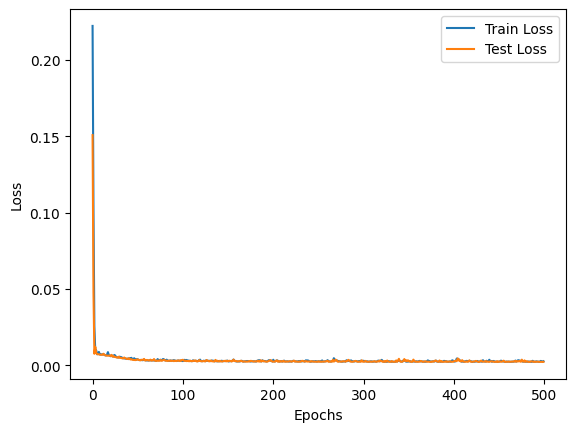

In [27]:
plt.plot(np.arange(config['epochs']), train_loss, label='Train Loss')
plt.plot(np.arange(config['epochs']), test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
def predict(model, test_loader):
    # Inference loop
    predictions = []
    ground_truth = []

    for i, batch in enumerate(test_loader):
      features, labels = batch[0].to(device).to(torch.float32), batch[1].to(device).to(torch.float32)

      # Perform inference
      with torch.no_grad():
          logits = model(features.unsqueeze(1))
      #print(f'Logits {logits.shape}')
      # Get the last time step prediction
      prediction = logits[:, -1, :]
      #print(f'Predictions {prediction.shape}')
      #print(f'Labels {labels.shape}')

      # Inverse transform to get values in the original scale
      prediction = scaler.inverse_transform(prediction.cpu().numpy())
      label = scaler.inverse_transform(labels.unsqueeze(1).cpu().numpy())
      # Append predictions and ground truth to the lists
      predictions.extend(prediction.squeeze())
      ground_truth.extend(label.squeeze())

    return predictions, ground_truth

In [29]:
predictions, ground_truth = predict(model, test_stock_loader)
print(f'Predictions Shape {len(predictions)}')
print(f'Ground Truth Shape {len(ground_truth)}')

Predictions Shape 103
Ground Truth Shape 103


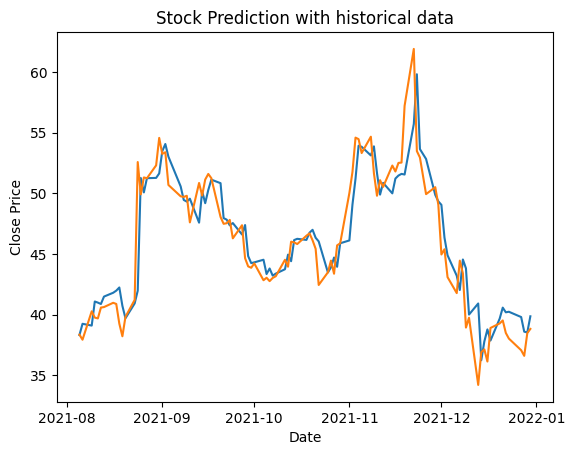

In [30]:
test_size = int(len(dates) * config['parition_size'])
plt.title('Stock Prediction with historical data')
plt.plot(pd.to_datetime(dates[test_size:]), predictions, label='Predicted')
plt.plot(pd.to_datetime(dates[test_size:]), ground_truth, label='Ground Truth')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


# 2. Stock Predicition with Historical Data and Sentiment Analysis

## 1. Import GME Stock related Reddit posts:
https://dataverse.harvard.edu/api/access/datafile/6370001

In [31]:
def load_sentiment_data(filename):
    data = requests.get('https://dataverse.harvard.edu/api/access/datafile/6370001')
    try:
        FILE_DEST = os.path.join(filename)
        if os.path.exists(FILE_DEST):
            print("Sentiment data fetched successfully")
    except Exception:
        print("Exception occured while fectching sentiments data")

In [91]:
load_sentiment_data('rGME_dataset_features.csv')

Sentiment data fetched successfully


In [113]:
sentiments = pd.read_csv('rGME_dataset_features.csv')
sentiments.head()
#sentiments.columns

<ipython-input-113-33d8bceb75c3>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  sentiments = pd.read_csv('rGME_dataset_features.csv')


,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,...,0,0,6,0,0,0,0,0,0,0
1,1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,...,0,0,3,0,0,0,0,0,0,0
2,2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,...,0,0,0,0,0,0,0,0,0,0
3,3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,2021-01-05,NaN,-0.2960,...,1,0,0,0,0,0,0,0,0,0
4,4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,2021-01-06,NaN,0.0000,...,0,0,0,1,0,0,0,0,0,0


## 2. Feature Extraction
- We get sentiment scores (pos, neg, neu) and date from the Reddit post dataset
- Merge stock data and sentiment scores as one data stream

In [114]:
data.head()

,Date,Close(t-9),Close(t-8),Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1),Close
253,2021-01-04,0.037220,0.036930,0.048330,0.051551,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919
254,2021-01-05,0.036930,0.048330,0.051551,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.042267
255,2021-01-06,0.048330,0.051551,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.042267,0.045139
256,2021-01-07,0.051551,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.042267,0.045139,0.044327
257,2021-01-08,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.042267,0.045139,0.044327,0.043196


In [115]:
stock_sentiment = data.merge(pd.DataFrame(sentiments, columns=['pos','neg','neu']), how='inner', left_index=True, right_index=True)
stock_sentiment.head()

,Date,Close(t-9),Close(t-8),Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1),Close,pos,neg,neu
253,2021-01-04,0.037220,0.036930,0.048330,0.051551,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.000,0.000,1.000
254,2021-01-05,0.036930,0.048330,0.051551,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.042267,0.414,0.057,0.529
255,2021-01-06,0.048330,0.051551,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.042267,0.045139,0.382,0.000,0.618
256,2021-01-07,0.051551,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.042267,0.045139,0.044327,0.000,0.730,0.270
257,2021-01-08,0.050332,0.052769,0.048098,0.047750,0.046532,0.041919,0.042267,0.045139,0.044327,0.043196,0.000,0.000,1.000


## 3. Exploratory Data Analysis
- Visualize Sentiment Scores over time (year 2021)

In [116]:
posts_dates = stock_sentiment[(stock_sentiment['Date'] >= START_DATE) & (stock_sentiment['Date'] <= END_DATE)]

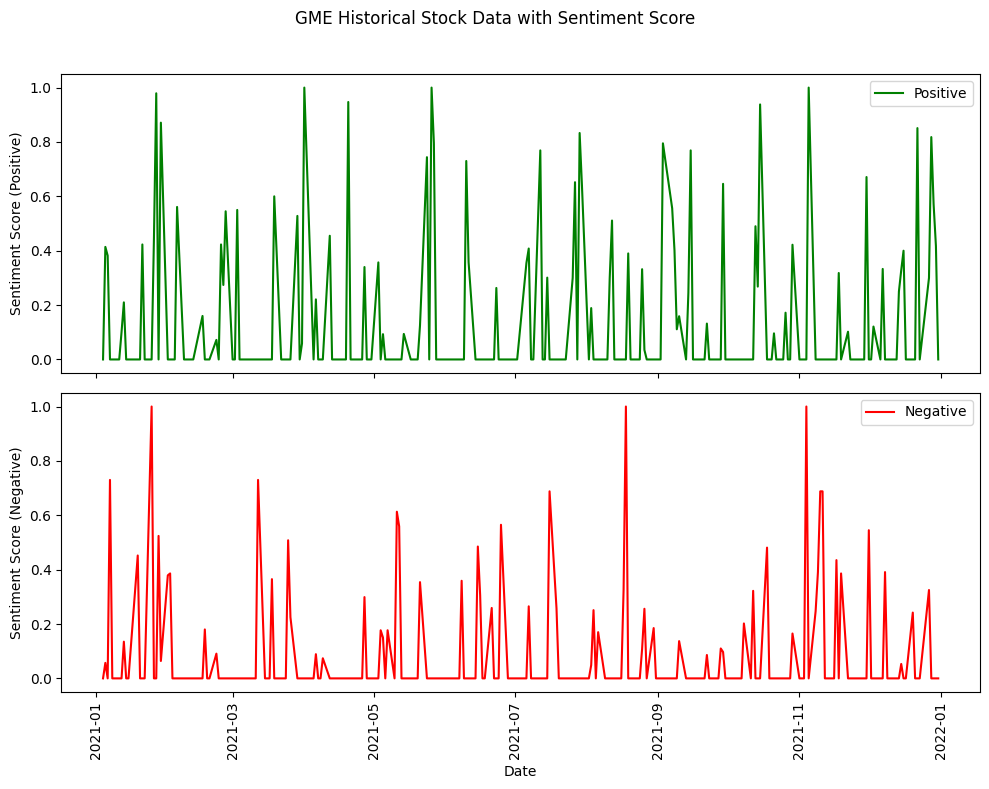

In [131]:
period = pd.to_datetime(posts_dates['Date'])
period = period.sort_values()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plot positive sentiment
ax1.plot(period, stock_sentiment['pos'], label='Positive', color='green')
ax1.set_ylabel('Sentiment Score (Positive)')
ax1.legend()

# Plot negative sentiment
ax2.plot(period, stock_sentiment['neg'], label='Negative', color='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Sentiment Score (Negative)')
ax2.legend()

# Adjust layout and display the plot
plt.xticks(rotation=90)
plt.suptitle('GME Historical Stock Data with Sentiment Score')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to prevent overlap
plt.show()

In [138]:
pos_mean = stock_sentiment['pos'].mean()
print(f'GME Positive Sentiment mean score of 2021 {pos_mean}')
neg_mean = stock_sentiment['neg'].mean()
print(f'GME Negative Sentiment mean score of 2021 {neg_mean}')
neu_mean = stock_sentiment['neu'].mean()
print(f'GME Neutral Sentiment mean score of 2021 {neu_mean}')

GME Positive Sentiment mean score of 2021 0.13418253968253968
GME Negative Sentiment mean score of 2021 0.08269444444444445
GME Neutral Sentiment mean score of 2021 0.7831190476190476


Overall stock had highest neutral sentiment score in year 2021 on Reddit. Note that sentiment scores are from the datasets

## 4. Dataset - Stock Data and Sentiment Score Data Modeling

 Divide stock data into training and testing sets, create corresponding datasets, and initializes data loaders for efficient processing.

In [ ]:
dates = data['Date']
train_x, test_x, train_y, test_y = train_test_split(stock_sentiment)

train_stock_data = StockDataset(train_x, train_y)
test_stock_data = StockDataset(test_x, test_y)
train_stock_loader = torch.utils.data.DataLoader(train_stock_data, batch_size=config['batch_size'], shuffle=True)
test_stock_loader = torch.utils.data.DataLoader(test_stock_data, batch_size=config['batch_size'], shuffle=False)

print("Train dataset samples = {}, batches = {}".format(train_stock_data.__len__(), len(train_stock_loader)))
print("Test dataset samples = {}, batches = {}".format(test_stock_data.__len__(), len(test_stock_loader)))

Train dataset samples = 103, batches = 11
Test dataset samples = 103, batches = 11
